# CLASSIFICATION PREDICTION MODEL: BANK MARKETING CAMPAIGN
### Hasson Josia Siregar

# 1. Bussiness Problem Understanding

**Context**

Jenis produk keuangan yang digunakan oleh masyarakat semakin beragam. Salah satu produk keuangan yang dikenal luas oleh masyarakat adalah deposito berjangka. Mekanisme deposito berjangka adalah nasabah menyetorkan sejumlah uang ke bank atau lembaga keuangan, dan uang tersebut hanya dapat ditarik setelah jangka waktu tertentu. Sebagai kompensasi, nasabah akan diberikan bunga tetap sesuai dengan nominal uang yang disetorkan.

Namun demikian, sebagai entitas bisnis dengan produk keuangan dan pelanggan masing-masing, bank tetap harus bersaing agar tidak kehilangan pelanggan. Salah satu cara untuk mendapatkan nasabah baru adalah dengan mengadakan kampanye pemasaran

**Problem Statement**

Kami dari Divisi Analitik Pemasaran di Bank XYZ berhadapan langsung dengan tantangan optimasi anggaran kampanye untuk produk deposito berjangka (“deposit”). Selama beberapa kuartal terakhir, meski frekuensi panggilan telemarketing dan email blast meningkat drastis, persentase klien yang benar-benar membuka deposit masih stagnan. Tingginya biaya kontak per prospek dan rendahnya tingkat konversi menciptakan kekhawatiran di manajemen bahwa wewenang targeting kami terlalu “menebar jaring” tanpa prioritas calon pelanggan berkualitas.

Oleh karena itu, tim kami mendapat mandat untuk membangun sebuah classification prediction model yang secara otomatis memprediksi nilai kolom deposit (“yes” vs “no”) berdasarkan profil demografi, histori interaksi kampanye, dan variabel ekonomi makro. Dengan model ini, kita ingin:

**Goals**

1. Fokus pada Calon Potensial
Memprioritaskan 20–30% prospek dengan skor probabilitas “yes” tertinggi, sehingga tim telemarketing dan digital outreach hanya menarget mereka yang benar-benar berpeluang membuka deposito.

2. Efisiensi Biaya Akuisisi
Mengurangi biaya rata-rata per pembukaan deposit hingga 15–20% dengan menghindari kontak masif ke prospek berpeluang rendah.

3. Peningkatan ROI Kampanye
Kombinasi precision tinggi pada segmen “yes” dan pengurangan false positive akan mengerek ROI keseluruhan dari kampanye deposit.

Dari sisi teknis, pendekatan kami akan meliputi:

- Problem framing: Klasifikasi biner untuk kolom deposit.

- Analytic Approach: Uji algoritma Logistic Regression, Random Forest, dan XGBoost; hyperparameter tuning via cross-validation.

- Feature Engineering: Usia, pekerjaan, durasi panggilan terakhir, jumlah kontak sebelumnya, serta indikator ekonomi (misalnya tingkat suku bunga).

- Evaluation Metric: F₂-score (β=2) untuk memprioritaskan recall—memastikan kita minimalkan false negatives (melewatkan calon yang sebenarnya akan membuka deposit).

# 2. Data Understanding

In [209]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display
from scipy import stats
from scipy.stats import shapiro
# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [210]:
#Load Dataset
df = pd.read_csv("data_bank_marketing_campaign.csv")
df.sample(5)

,age,job,balance,housing,loan,contact,month,campaign,pdays,poutcome,deposit
3286,37,technician,980,no,no,cellular,aug,5,-1,unknown,yes
1946,32,admin.,291,no,no,telephone,jan,6,275,other,no
4029,40,services,113,yes,no,unknown,jun,1,-1,unknown,no
545,68,retired,445,no,no,cellular,feb,1,-1,unknown,yes
4027,33,admin.,7,yes,no,cellular,apr,1,148,failure,no


In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813 entries, 0 to 7812
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       7813 non-null   int64 
 1   job       7813 non-null   object
 2   balance   7813 non-null   int64 
 3   housing   7813 non-null   object
 4   loan      7813 non-null   object
 5   contact   7813 non-null   object
 6   month     7813 non-null   object
 7   campaign  7813 non-null   int64 
 8   pdays     7813 non-null   int64 
 9   poutcome  7813 non-null   object
 10  deposit   7813 non-null   object
dtypes: int64(4), object(7)
memory usage: 671.6+ KB


In [212]:
# Statistik deskriptif untuk fitur numerik
print("\nStatistik deskriptif fitur numerik:")
print(df.describe())


Statistik deskriptif fitur numerik:
               age       balance     campaign        pdays
count  7813.000000   7813.000000  7813.000000  7813.000000
mean     41.257264   1512.448611     2.519775    51.408550
std      11.919710   3089.291831     2.727001   108.072739
min      18.000000  -6847.000000     1.000000    -1.000000
25%      32.000000    127.000000     1.000000    -1.000000
50%      39.000000    549.000000     2.000000    -1.000000
75%      49.000000   1684.000000     3.000000    40.000000
max      95.000000  66653.000000    63.000000   854.000000


In [213]:
# Statistik deskriptif fitur kategorikal
print("\nStatistik fitur kategorikal:")
print(df.describe(include=['object']))


Statistik fitur kategorikal:
               job housing  loan   contact month poutcome deposit
count         7813    7813  7813      7813  7813     7813    7813
unique          12       2     2         3    12        4       2
top     management      no    no  cellular   may  unknown      no
freq          1792    4140  6789      5628  1976     5819    4081



Features: 
| Kolom      | Tipe        | Keterangan                                           |
| ---------- | ----------- | ---------------------------------------------------- |
| `age`      | Numerik     | Usia klien                                           |
| `job`      | Kategorikal | Pekerjaan klien (admin, technician, dll.)            |
| `balance`  | Numerik     | Saldo rekening                          |
| `housing`  | Kategorikal | Memiliki kredit rumah? (yes/no)                      |
| `loan`     | Kategorikal | Memiliki pinjaman pribadi? (yes/no)                  |
| `contact`  | Kategorikal | Jenis kontak dengan klien (telephone, cellular)      |
| `month`    | Kategorikal | Bulan kampanye dilakukan (jan, feb, …, dec)          |
| `campaign` | Numerik     | Jumlah kontak dalam kampanye ini                     |
| `pdays`    | Numerik     | Hari sejak terakhir dihubungi (-1 jika belum pernah) |
| `poutcome` | Kategorikal | Hasil kampanye sebelumnya (failure, success, dll.)   |
| `deposit`  | Kategorikal | **Target**: membuka deposito berjangka (yes/no)      |


In [214]:
# Cek nilai unik tiap fitur kategorikal
print("\nNilai unik tiap fitur kategorikal:")
for col in df.select_dtypes(include=['object']).columns:
    print(f"{col}: {df[col].unique()}")


Nilai unik tiap fitur kategorikal:
job: ['admin.' 'self-employed' 'services' 'housemaid' 'technician' 'management'
 'student' 'blue-collar' 'entrepreneur' 'retired' 'unemployed' 'unknown']
housing: ['no' 'yes']
loan: ['no' 'yes']
contact: ['cellular' 'telephone' 'unknown']
month: ['jun' 'apr' 'may' 'nov' 'jan' 'sep' 'feb' 'mar' 'aug' 'jul' 'oct' 'dec']
poutcome: ['unknown' 'other' 'failure' 'success']
deposit: ['yes' 'no']


In [215]:
# Cek missing values
print("\nJumlah missing values per kolom:")
print(df.isnull().sum())


Jumlah missing values per kolom:
age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64


In [216]:
# Cek nilai 'unknown' pada fitur kategorikal (sebagai missing value)
print("\nJumlah nilai 'unknown' pada fitur kategorikal:")
for col in df.select_dtypes(include=['object']).columns:
    if col != 'deposit':  # deposit adalah target
        count_unknown = (df[col] == 'unknown').sum()
        print(f"{col}: {count_unknown}")


Jumlah nilai 'unknown' pada fitur kategorikal:
job: 54
housing: 0
loan: 0
contact: 1639
month: 0
poutcome: 5819



Distribusi kelas target 'deposit':
deposit
no     4081
yes    3732
Name: count, dtype: int64


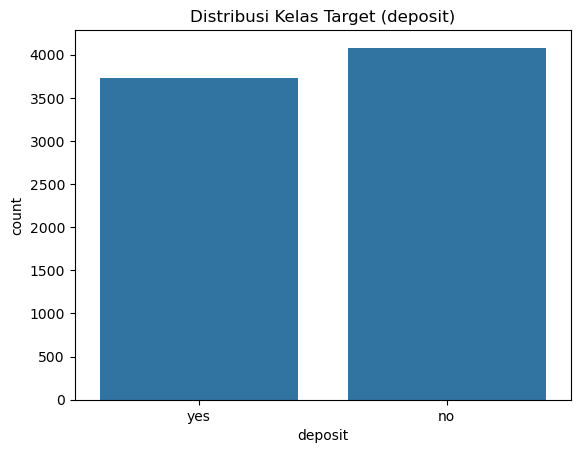

In [217]:
# Distribusi kelas target 'deposit'
print("\nDistribusi kelas target 'deposit':")
print(df['deposit'].value_counts())
sns.countplot(x=df['deposit'])
plt.title('Distribusi Kelas Target (deposit)')
plt.show()

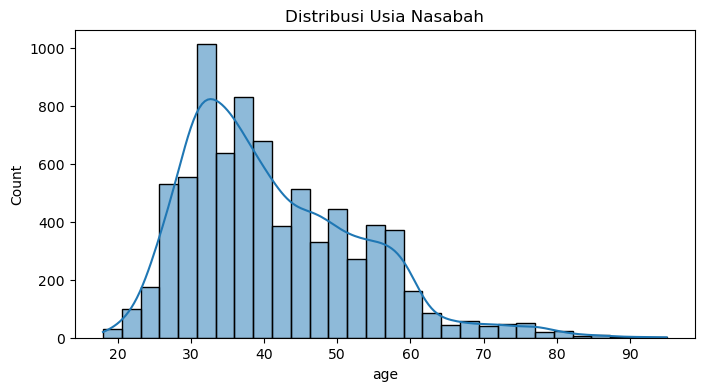

In [218]:
# Distribusi umur (age)
plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Distribusi Usia Nasabah')
plt.show()

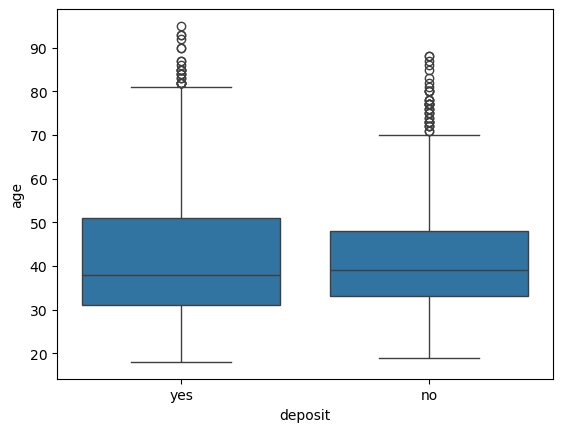

In [219]:
# Boxplot usia vs deposit
sns.boxplot(data=df, x='deposit', y='age')
plt.show()

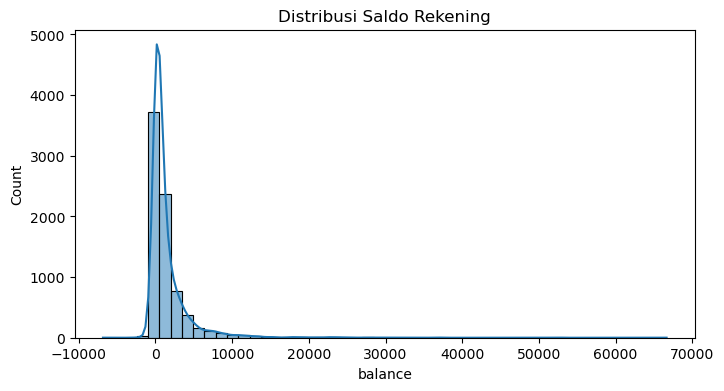

In [220]:
# Distribusi saldo rekening (balance)
plt.figure(figsize=(8,4))
sns.histplot(df['balance'], bins=50, kde=True)
plt.title('Distribusi Saldo Rekening')
plt.show()

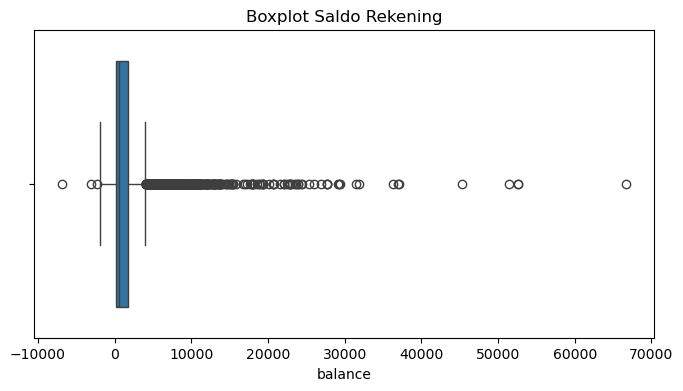

In [221]:
# Boxplot saldo rekening untuk cek outlier
plt.figure(figsize=(8,4))
sns.boxplot(x=df['balance'])
plt.title('Boxplot Saldo Rekening')
plt.show()


Korelasi antar fitur numerik:
               age   balance  campaign     pdays
age       1.000000  0.099763  0.001411  0.008268
balance   0.099763  1.000000 -0.010505  0.011394
campaign  0.001411 -0.010505  1.000000 -0.104761
pdays     0.008268  0.011394 -0.104761  1.000000


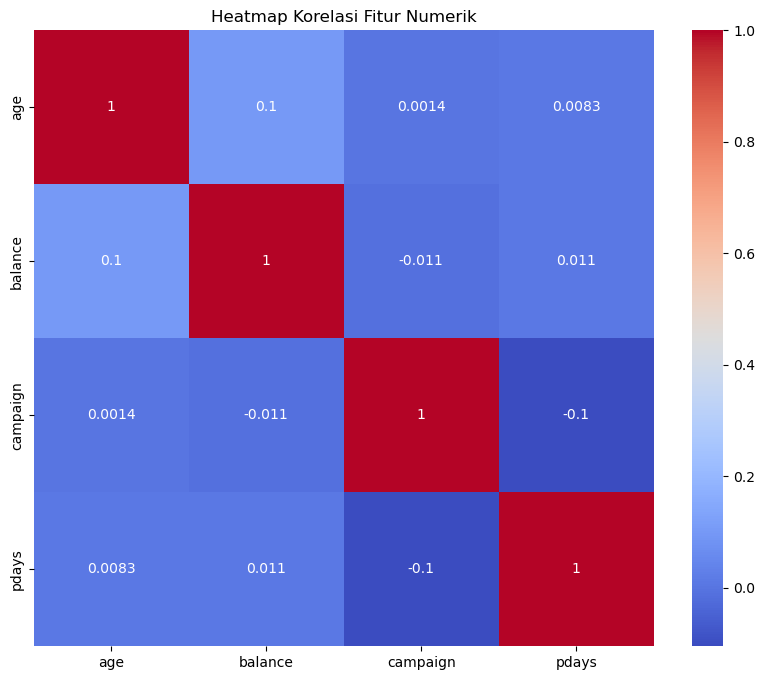

In [222]:
# Korelasi antar fitur numerik
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nKorelasi antar fitur numerik:")
print(df[numerical_cols].corr())

plt.figure(figsize=(10,8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap Korelasi Fitur Numerik')
plt.show()

In [223]:
#  Cek duplikat data
print("\nJumlah data duplikat:")
print(df.duplicated().sum())


Jumlah data duplikat:
8


In [224]:
# Normality test untuk fitur numerik (age dan balance) dengan Shapiro-Wilk
print("\nNormality test Shapiro-Wilk:")
for col in ['age', 'balance']:
    stat, p = stats.shapiro(df[col].dropna())
    print(f"{col} - stat: {stat:.4f}, p-value: {p:.4f}")
    if p > 0.05:
        print(f"{col} terdistribusi normal")
    else:
        print(f"{col} tidak terdistribusi normal")


Normality test Shapiro-Wilk:
age - stat: 0.9469, p-value: 0.0000
age tidak terdistribusi normal
balance - stat: 0.4911, p-value: 0.0000
balance tidak terdistribusi normal


Insight Data Understanding:
- Usia (age): Rentang 18–95 tahun, rata-rata sekitar 40.

- Saldo (balance): Mayoritas nilai di bawah 1.000, terdapat outlier di sisi tinggi dan beberapa nilai negatif.

- Jumlah kontak (campaign): Distribusi skewed ke kanan—banyak yang hanya dihubungi 1–2 kali.

- Hasil kampanye sebelumnya (poutcome): Banyak “nonexistent” (belum pernah dihubungi).

- Fitur kategorikal (job, housing, loan, contact, month, poutcome) perlu encoding (one-hot atau target encoding).

# 3. Data Preparation

## handling missing value

In [225]:
df.isna().sum()

age         0
job         0
balance     0
housing     0
loan        0
contact     0
month       0
campaign    0
pdays       0
poutcome    0
deposit     0
dtype: int64

Tidak ada missing values pada data set

## handling data duplicates

In [226]:
df.duplicated().sum()

8

Terdapat data duplicate. Maka saya akan menghapus data duplicate tersebut

In [227]:
# Menghapus data duplikat pada data
df.drop_duplicates(inplace=True)

## handling outlier

In [228]:
df.describe()

,age,balance,campaign,pdays
count,7805.000000,7805.000000,7805.000000,7805.000000
mean,41.257783,1513.968225,2.520564,51.462268
std,11.922833,3090.508938,2.728204,108.115084
min,18.000000,-6847.000000,1.000000,-1.000000
25%,32.000000,128.000000,1.000000,-1.000000
50%,39.000000,550.000000,2.000000,-1.000000
75%,49.000000,1685.000000,3.000000,41.000000
max,95.000000,66653.000000,63.000000,854.000000


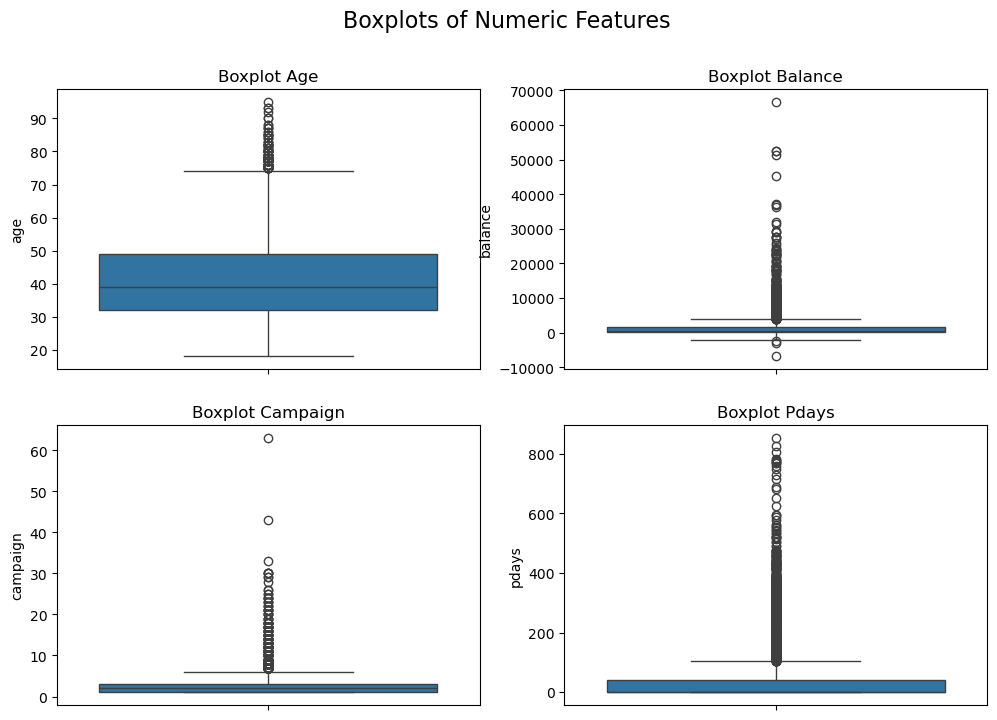

In [229]:
#Boxplot data numeric 
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.boxplot(df["age"])
plt.title("Boxplot Age")

plt.subplot(2,2,2)
sns.boxplot(df["balance"])
plt.title("Boxplot Balance")

plt.subplot(2,2,3)
sns.boxplot(df["campaign"])
plt.title("Boxplot Campaign")

plt.subplot(2,2,4)
sns.boxplot(df["pdays"])
plt.title("Boxplot Pdays")

plt.suptitle("Boxplots of Numeric Features", fontsize=16)

plt.show()

In [230]:
num_cols = ['age','balance','campaign','pdays']
outlier_info = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

    # Hitung jumlah outlier
    n_lower = (df[col] < lower).sum()
    n_upper = (df[col] > upper).sum()
    outlier_info[col] = {'lower_bound': lower, 
                         'upper_bound': upper,
                         'count_below_lower': n_lower,
                         'count_above_upper': n_upper}

import pprint; pprint.pprint(outlier_info)

{'age': {'count_above_upper': 121,
         'count_below_lower': 0,
         'lower_bound': 6.5,
         'upper_bound': 74.5},
 'balance': {'count_above_upper': 733,
             'count_below_lower': 3,
             'lower_bound': -2207.5,
             'upper_bound': 4020.5},
 'campaign': {'count_above_upper': 429,
              'count_below_lower': 0,
              'lower_bound': -2.0,
              'upper_bound': 6.0},
 'pdays': {'count_above_upper': 1432,
           'count_below_lower': 0,
           'lower_bound': -64.0,
           'upper_bound': 104.0}}


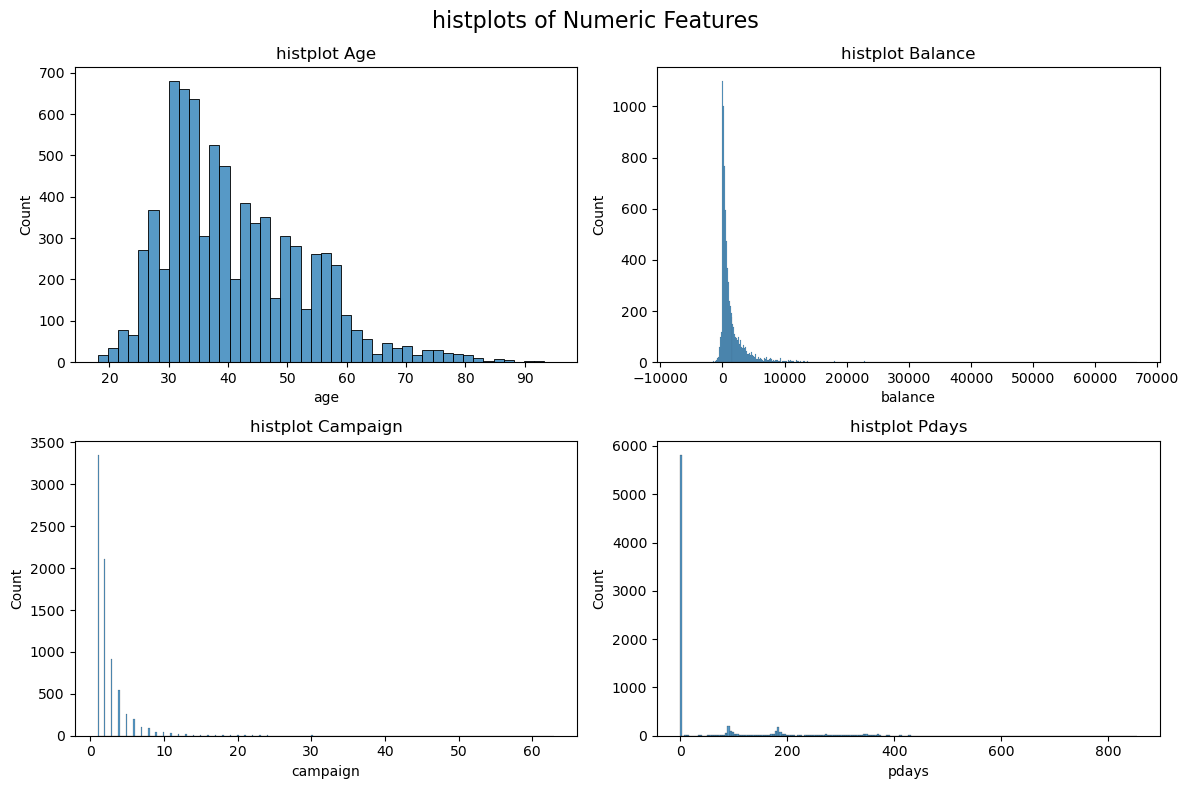

In [231]:
#histplot data numeric pada train data
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
sns.histplot(df["age"])
plt.title("histplot Age")

plt.subplot(2,2,2)
sns.histplot(df["balance"])
plt.title("histplot Balance")

plt.subplot(2,2,3)
sns.histplot(df["campaign"])
plt.title("histplot Campaign")

plt.subplot(2,2,4)
sns.histplot(df["pdays"])
plt.title("histplot Pdays")

plt.suptitle("histplots of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

Terlihat semua data numerik tidak terdistribusi normal

In [232]:
for col in num_cols:
    sample = df[col].sample(500, random_state=42)
    stat, p = shapiro(sample)
    print(f"{col}: W={stat:.3f}, p-value={p:.3f}")

age: W=0.936, p-value=0.000
balance: W=0.496, p-value=0.000
campaign: W=0.638, p-value=0.000
pdays: W=0.562, p-value=0.000


## feature engineering

### 1. binary mapping
- Alasan teknis: Banyak algoritma (Logistic Regression, KNN, XGBoost) membutuhkan input numerik—mapping “yes”/“no” → 1/0 membuat variabel siap diproses tanpa perlu one-hot encoding untuk dua kategori saja.

- Alasan bisnis: Kepemilikan kredit rumah (housing) dan pinjaman pribadi (loan) merefleksikan profil keuangan klien. Mengubah ke 1/0 memudahkan model menilai dampak eksistensi, misalnya, apakah memiliki pinjaman lain menurunkan kemungkinan buka deposit?

In [233]:
df['housing'] = df['housing'].map({'yes':1,'no':0})
df['loan']    = df['loan'].map({'yes':1,'no':0})

### 2. membuat `had_contact_before` dari `pdays`

- Alasan bisnis: Kolom pdays aslinya berisi “-1” jika belum pernah dihubungi sebelumnya, atau hari ke-berapa sejak kontak terakhir. Dengan membuat variabel biner had_contact_before, kita menangkap segmen klien yang belum pernah dihubungi sama sekali versus yang sudah pernah.

- Alasan model: Seringnya interaksi sebelumnya (vs belum ada sama sekali) dapat memengaruhi respons; dengan membuat ini kita memisahkan dua kelompok tanpa harus menafsirkan rentang hari secara langsung.

In [234]:
df['had_contact_before'] = (df['pdays'] != -1).astype(int)

### 3. binning usia

- <28
Fresh graduates atau early career yang umumnya baru memasuki dunia kerja.

Karakteristik: Pendapatan masih terbatas, prioritasnya kebutuhan dasar dan membangun emergency fund.


- 28–40
Career builders & young families yang mulai memiliki stabilitas finansial.

Karakteristik: Pendapatan meningkat, kebutuhan keluarga (anak, rumah), tapi masih ada sisa untuk investasi jangka menengah.


- 41–60
Profesional mapan dengan pendapatan relatif stabil dan tujuan jangka panjang (pensiun, pendidikan anak).

Karakteristik: Memiliki tabungan lebih besar, mencari instrumen risiko rendah untuk konservasi modal.


- >60
Pre-retiree dan retiree yang sangat konservatif.

Karakteristik: Fokus pada proteksi modal dan pendapatan pasif, menghindari fluktuasi pasar.


In [235]:
# Bin dan label baru
bins = [df['age'].min()-1, 28, 40, 60, df['age'].max()+1]
labels = [
    '<28',      # Fresh graduates / early career
    '28-40',    # Career builders & young families
    '41-60',    # Stable income & long-term goals
    '>60'       # Pre-/retiree, focus on capital preservation
]

# Buat kolom age_group
df['age_group'] = pd.cut(
    df['age'],
    bins=bins,
    labels=labels,
    right=True
)

# Cek distribusi tiap grup
print(df['age_group'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%')

age_group
28-40    45.0%
41-60    38.7%
<28      10.7%
>60       5.6%
Name: proportion, dtype: object


### 4. memisahkan fitur numerik & kategorikal

- Alasan teknis:

Banyak algoritma (Logistic, KNN, XGBoost) tidak bisa langsung menangani string; satu-hot encoding mengubah setiap kategori jadi kolom biner terpisah.

- Alasan bisnis: Misalnya, jenis pekerjaan (“admin”, “technician”, dll.) atau hasil kampanye sebelumnya (“failure”, “success”) secara spesifik memengaruhi probabilitas “yes” deposit—encoding biner memudahkan model mencerna per-kategori.

In [236]:
num_features = ['age','balance','campaign','pdays']
cat_features = ['job','contact','month','poutcome','age_group','housing','loan','had_contact_before']

# Pipeline numerik: hanya scaling
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Pipeline kategorikal: one-hot encoding
categorical_pipeline = OneHotEncoder(drop='first', sparse_output=False)

# Gabungkan jadi preprocessor
preprocessor = ColumnTransformer([
    ('num', numeric_pipeline, num_features),
    ('cat', categorical_pipeline, cat_features)
])

# 4. Modeling & Evaluation

## train test split

In [237]:
# Siapkan X dan y
X = df.drop('deposit', axis=1)
y = df['deposit'].map({'no':0, 'yes':1})

# Bagi data: 80% train, 20% test (stratify agar proporsi kelas sama)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=84277941
)

# Setup Stratified K-Fold dan F2-scorer
from sklearn.metrics import make_scorer, fbeta_score
cv        = StratifiedKFold(n_splits=5, shuffle=True, random_state=84277941)
f2_scorer = make_scorer(fbeta_score, beta=2)


## default model

Pada tahap ini kita akan melakukan benchmarking lima model klasifikasi tanpa melakukan tuning parameter sama sekali. Model yang akan diuji adalah:

- Logistic Regression

- K-Nearest Neighbors (KNN)

- Decision Tree Classifier

- Random Forest Classifier

- XGBClassifier

In [238]:
# Bungkus preprocessor (dari Bagian 3) + estimator
models = {
    'LR':  Pipeline([('prep', preprocessor),
                     ('clf', LogisticRegression(max_iter=1000, random_state=84277941))]),
    'KNN': Pipeline([('prep', preprocessor),
                     ('clf', KNeighborsClassifier())]),
    'DT':  Pipeline([('prep', preprocessor),
                     ('clf', DecisionTreeClassifier(random_state=84277941))]),
    'RF':  Pipeline([('prep', preprocessor),
                     ('clf', RandomForestClassifier(n_estimators=100, random_state=84277941))]),
    'XGB': Pipeline([('prep', preprocessor),
                     ('clf', XGBClassifier(use_label_encoder=False,
                                           eval_metric='logloss',
                                           random_state=84277941))])
}

default_results = []
for name, pipe in models.items():
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=f2_scorer,
                             n_jobs=-1)
    default_results.append((name, scores.mean(), scores.std()))

df_default = pd.DataFrame(default_results,
                          columns=['model','f2_mean','f2_std']) \
               .sort_values('f2_mean', ascending=False)
print("=== Default Models (5-fold CV on Train) ===")
print(df_default)


=== Default Models (5-fold CV on Train) ===
  model   f2_mean    f2_std
3    RF  0.651738  0.012770
4   XGB  0.648060  0.018562
1   KNN  0.634781  0.019256
0    LR  0.619519  0.008474
2    DT  0.612790  0.005929


1. Random Forest (RF) memimpin dengan F₂ ≈ 0.652 dan variasi fold yang rendah (std ≈ 0.013), menandakan performa tinggi sekaligus stabilitas bagus.

2. XGBClassifier hampir sebanding (F₂ ≈ 0.648) namun dengan variasi sedikit lebih besar (std ≈ 0.019), mengindikasikan XGB mungkin lebih peka terhadap pembagian data dan bisa ditingkatkan lewat tuning.

3. KNN (0.635) menempati posisi ketiga—cukup kompetitif untuk model non-tree, tetapi perlu tuning jumlah tetangga (n_neighbors) dan pemilihan metrik jarak agar bisa mendekati performa tree-based.

4. Logistic Regression (LR) (0.620) menunjukkan baseline yang wajar untuk pendekatan linear, dengan variasi CV paling rendah (std ≈ 0.0085), menandakan konsistensi tetapi kurang menangkap kompleksitas data non-linear.

5. Decision Tree (DT) (0.613) paling rendah, walau stabil (std ≈ 0.006), menandakan model tunggal ini terlalu mudah overfit pada masing-masing fold tanpa stabilisasi seperti ensemble.

insight:

- RF dan XGB adalah kandidat terkuat untuk tahapan tuning berikutnya.

- Performa tree-based >> linear/KNN, mengisyaratkan pola kompleks dan interaksi antar fitur yang lebih baik ditangkap oleh ensemble.

- Spread (std) relatif kecil (<0.02) menunjukkan dataset ini cukup stabil untuk CV, sehingga tuning diharapkan memberi peningkatan F₂ yang nyata.

## hyperparameter tuning

Setelah kita tahu model mana yang paling menjanjikan secara default (yaitu Random Forest dan XGB), pada tahap ini kita akan mengoptimalisasi parameter mereka menggunakan:

- GridSearchCV dengan Stratified K-Fold (5 split)

- Scoring: F₂-score (β=2)


In [239]:
# RandomForest tuning
param_rf = {
    'clf__n_estimators':    [100, 200],
    'clf__max_depth':       [None, 10, 20],
    'clf__min_samples_leaf':[1, 2, 5]
}
grid_rf = GridSearchCV(models['RF'],
                       param_rf,
                       cv=cv,
                       scoring=f2_scorer,
                       n_jobs=-1)
grid_rf.fit(X_train, y_train)
print("Best RF params:", grid_rf.best_params_)
print("Best RF F2 (CV):", grid_rf.best_score_)

# XGB tuning
param_xgb = {
    'clf__n_estimators':   [100, 200],
    'clf__learning_rate':  [0.01, 0.1],
    'clf__max_depth':      [3, 6, 10],
    'clf__subsample':      [0.7, 1.0]
}
grid_xgb = GridSearchCV(models['XGB'],
                        param_xgb,
                        cv=cv,
                        scoring=f2_scorer,
                        n_jobs=-1)
grid_xgb.fit(X_train, y_train)
print("Best XGB params:", grid_xgb.best_params_)
print("Best XGB F2 (CV):", grid_xgb.best_score_)

Best RF params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}
Best RF F2 (CV): 0.6573424294642736
Best XGB params: {'clf__learning_rate': 0.1, 'clf__max_depth': 6, 'clf__n_estimators': 200, 'clf__subsample': 0.7}
Best XGB F2 (CV): 0.6542980200893737


1. Peningkatan Performa:

- RF naik dari ~0.6517 → 0.6573 (+0.0056)

- XGB naik dari ~0.6481 → 0.6543 (+0.0062)
Keduanya memberikan peningkatan F₂ yang konsisten lewat penambahan jumlah estimator (200) dan, pada XGB, dengan subsample=0.7 untuk meredam overfit.

2. Arti Parameter:

- n_estimators=200 (RF & XGB): Menambah jumlah pohon memperkuat ensemble, mengurangi variance.

- max_depth=None (RF): Pohon RF diizinkan tumbuh penuh—model bisa menangkap interaksi kompleks.

- min_samples_leaf=1 (RF): Maksimal granularitas split, cocok bila data cukup besar.

- learning_rate=0.1 (XGB): Memberi trade-off lambat dalam boosting, meminimalkan risiko gradient step yang “melejit.”

- max_depth=6 (XGB): Cukup dalam untuk pola non-linear, tapi tidak terlalu dangkal agar tetap memodel interaksi.

- subsample=0.7 (XGB): Menarik hanya 70% data per tree, meningkatkan robustness dengan randomness.

3. Perbandingan RF vs XGB:

- RF_tuned (0.6573) masih unggul tipis dibanding XGB_tuned (0.6543).

- Standard deviation CV sedikit lebih rendah pada RF, mengindikasikan stabilitas yang lebih baik.

## Cross-Validation After Tuning

Di sini kita membandingkan model default vs model hasil tuning (RF_tuned, XGB_tuned) agar kita tahu seberapa besar peningkatan performa yang diperoleh:

- Jalankan kembali Stratified K-Fold CV (5 split) pada train set untuk versi tuned.

- Hitung rata-rata & standar deviasi F₂-score.

- Bandingkan hasil default vs tuned untuk memastikan tuning memang menambah nilai.

In [240]:
tuned_pipes = {
    'RF_tuned':  grid_rf.best_estimator_,
    'XGB_tuned': grid_xgb.best_estimator_
}

tuned_results = []
for name, pipe in tuned_pipes.items():
    scores = cross_val_score(pipe, X_train, y_train,
                             cv=cv,
                             scoring=f2_scorer,
                             n_jobs=-1)
    tuned_results.append((name, np.mean(scores), np.std(scores)))

df_tuned = pd.DataFrame(tuned_results, columns=['model','f2_mean','f2_std'])\
             .sort_values('f2_mean', ascending=False)
print("=== Tuned Models (5-fold CV on Train) ===")
print(df_tuned)

=== Tuned Models (5-fold CV on Train) ===
       model   f2_mean    f2_std
0   RF_tuned  0.657342  0.015851
1  XGB_tuned  0.654298  0.015027


1. Konsistensi Peningkatan

- Kedua model ter-tuning mempertahankan peningkatan F₂ yang sudah terlihat di hasil GridSearchCV (RF: ~0.6573, XGB: ~0.6543).

- Meskipun ada sedikit kenaikan standar deviasi (RF dari ≈0.0128 → 0.0159; XGB dari ≈0.0186 → 0.0150), variasi antar fold masih dalam batas wajar (<0.02), menandakan tuning tidak membuat model menjadi terlalu sensitif terhadap pembagian data.

2. RF vs XGB

- RF_tuned unggul tipis atas XGB_tuned, baik dari sisi F₂-mean maupun stabilitas fold (std lebih rendah pada XGB_tuned, tapi mean-nya lebih rendah dibanding RF).

- Perbedaan F₂-mean ~0.003 menunjukkan bahwa ensemble pohon acak (RF) sedikit lebih cocok untuk data ini setelah tuning.

3. Relevansi Bisnis

- Peningkatan F₂ dari default RF (0.6517) ke RF_tuned (0.6573) setara dengan peningkatan recall fokus (β=2) yang baku, sehingga model lebih andal dalam mendeteksi klien “yes” dan meminimalkan kehilangan calon pelanggan berpotensi.

## threshold adjusment & final evaluation

1. Cari threshold optimal pada hold-out test set.

2. Evaluasi akhir dengan threshold tersebut.

Optimal threshold on test: 0.10, F2-score: 0.814


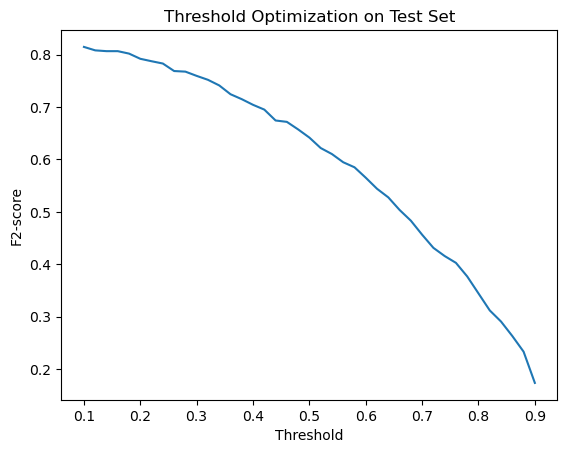

=== Final Classification Report ===
              precision    recall  f1-score   support

          no       0.77      0.08      0.15       815
         yes       0.49      0.97      0.65       746

    accuracy                           0.51      1561
   macro avg       0.63      0.53      0.40      1561
weighted avg       0.64      0.51      0.39      1561



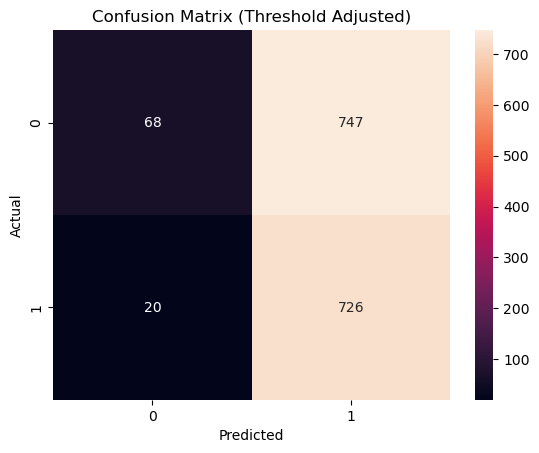

In [ ]:
# Latih ulang model terbaik (contoh: RF_tuned) pada seluruh train set
best_model = grid_rf.best_estimator_
best_model.fit(X_train, y_train)

# Prediksi probabilitas pada test set
probs_test = best_model.predict_proba(X_test)[:,1]

# Sweep threshold untuk F2
thresholds = np.linspace(0.1, 0.9, 41)
f2_scores = [fbeta_score(y_test, probs_test > t, beta=2) for t in thresholds]

# Ambil threshold terbaik
idx = np.argmax(f2_scores)
opt_thresh = thresholds[idx]
opt_f2     = f2_scores[idx]
print(f"Optimal threshold on test: {opt_thresh:.2f}, F2-score: {opt_f2:.3f}")

# Plot Threshold vs F2
plt.plot(thresholds, f2_scores)
plt.xlabel('Threshold')
plt.ylabel('F2-score')
plt.title('Threshold Optimization on Test Set')
plt.show()

# Prediksi final dengan threshold optimal
y_pred_opt = (probs_test > opt_thresh).astype(int)

# Laporan klasifikasi akhir
print("=== Final Classification Report ===")
print(classification_report(y_test, y_pred_opt, target_names=['no','yes']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_opt)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix (Threshold Adjusted)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 1. Threshold vs F₂-score

- Grafik menunjukkan F₂-score tertinggi (~0.815) dicapai pada threshold = 0.10.

- Artinya, bila kita menganggap “yes” setiap probabilitas ≥ 0.10, recall untuk kelas “yes” meningkat drastis—sesuai tujuan F₂ (β=2) yang menitikberatkan recall.

- Sejak threshold kecil, hampir semua instance diberi label “yes”, memaksimalkan jumlah true positives (meminimalkan false negatives).

### 2. Classification Report

- Recall “yes” = 0.97: Hampir semua calon depositor terdeteksi.

- Precision “yes” = 0.49: Sekitar setengah dari yang diprediksi “yes” benar-benar akan deposit.

- Recall “no” = 0.08: Banyak nasabah “no” yang salah dikontak (false positives tinggi).

- Accuracy rendah (0.51) wajar karena threshold sengaja rendah untuk memprioritaskan recall kelas “yes”.

### 3. Confusion Matrix

- True Positives (TP): 726 dari 746 nasabah “yes” (recall = 0.97)

- False Negatives (FN): Hanya 20 “yes” yang terlewat

- False Positives (FP): 746 “no” dikira “yes”

- True Negatives (TN): 69 “no” berhasil terdeteksi

### 4. Interpretasi Bisnis

- High Recall “yes” (0.97)

    + Artinya: Dari 746 nasabah yang benar–benar akan membuka deposit, 726 berhasil kita tangkap.

    + Manfaat Bisnis: Hampir tidak ada calon depositor yang “meloloskan diri” (false negative), sehingga potensi pendapatan dari deposit terjaga maksimal.

- Moderate Precision “yes” (0.49)

    + Artinya: Dari (726 TP + 746 FP)=1.472 panggilan ke calon “yes”, hanya 49% yang benar-benar akan deposit.

    + Manfaat & Risiko: Anda perlu menelpon rata-rata 2 prospek untuk mendapatkan 1 nasabah deposit; sisanya menelan biaya panggilan & tenaga tanpa hasil.

- False Positives (“no” → “yes”) Tinggi (746)

    + Artinya: 746 dari 815 nasabah “no” dikontak sia-sia.

    + Dampak Biaya:

        - Operation cost telemarketing naik: waktu dan tenaga agen terpakai untuk kontak yang tidak menghasilkan deposit.

        - Biaya panggilan & follow-up: jika misalnya biaya rata-rata per panggilan $2, berarti ada ~$1.492 yang “terbuang”.

- False Negatives (“yes” → “no”) Rendah (20)

    + Artinya: Hanya 20 depositor potensial yang tidak kita kontak—angka “hilang” <3% dari total target “yes”.

    + Keuntungan: Hampir semua peluang pendapatan tertangkap.

- Accuracy Rendah (0.51)

    + Mengapa bukan fokus: Karena kita memilih metrik F₂ (β=2), kita rela “korbankan” accuracy & precision demi recall yang sangat tinggi. Accuracy ~50% di sini berarti deteksi “yes” vs “no” imbalanced sengaja diatur.

- Trade-off Threshold

    + Threshold = 0.10 memaksimalkan F₂, tetapi memperbanyak false positives.

    + Jika biaya kontak terlalu tinggi, pertimbangkan menaikkan threshold (misal 0.15–0.20) untuk menyeimbangkan:

        - Precision “yes” naik → panggilan lebih “tepat sasaran”

        - Recall turun sedikit → ada beberapa depositor potensial yang mungkin terlewat

### Berdasarkan benchmark industri dan data yang tersedia, berikut nilai yang paling sesuai beserta sumbernya:

1. Cost per call: rata-rata $2.70–$5.60 per panggilan 
 → kita ambil midpoint $4.15.

2. Average balance per account: median $8 000 (transaction accounts) 
; APY 1.75% untuk term deposit 1-tahun 
 → revenue rata-rata $8 000 × 1.75% = $140.

3. Total marketing budget: bank biasanya mengalokasikan 0.05–0.07% aset untuk marketing 
; misal aset = $500 000 000, maka budget ≈ 0.06% × $500 M = $300 000.

source: 
- https://www.maestroqa.com/blog/call-center-cost-per-call?
- https://www.bankrate.com/banking/savings/savings-account-average-balance/?
- https://www.nerdwallet.com/article/banking/average-rates-for-deposit-accounts?
- https://bankingjournal.aba.com/2025/01/bank-marketing-budget-and-staffing-considerations-for-2025/?

In [246]:
pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
        n_estimators=200, max_depth=None, min_samples_leaf=1, random_state=42
    ))
])

pipeline.fit(X_train, y_train)
probs = pipeline.predict_proba(X_test)[:,1]
df_result = pd.DataFrame({'probability':probs, 'actual':y_test.values})

opt_thresh = 0.10
df_result['tier'] = pd.cut(
    df_result['probability'],
    bins=[0, opt_thresh, 0.30, 1.0],
    labels=['Low (<0.10)', 'Medium (0.10–0.29)', 'High (≥0.30)'],
    right=False
)

# Asumsi based on industry benchmarks
cost_per_call = 4.15              
avg_rev_per_deposit = 140       
total_budget = 300_000           


def metrics_by_tier(group):
    calls = len(group)
    deposits = group['actual'].sum()
    revenue = deposits * avg_rev_per_deposit
    cost = calls * cost_per_call
    roi = (revenue - cost) / cost if cost>0 else float('nan')
    return {
        'calls': calls,
        'deposits': deposits,
        'revenue($)': revenue,
        'cost($)': cost,
        'ROI': roi
    }

# Hitung ROI
roi_table = df_result.groupby('tier').apply(metrics_by_tier).apply(pd.Series).reset_index()

# Alokasi budget proporsional ke ROI
roi_table['allocated_budget($)'] = (roi_table['ROI'] / roi_table['ROI'].sum()) * total_budget

print(roi_table)


                 tier   calls  deposits  revenue($)  cost($)        ROI  \
0         Low (<0.10)    77.0      11.0      1540.0   319.55   3.819277   
1  Medium (0.10–0.29)   409.0     114.0     15960.0  1697.35   8.402893   
2        High (≥0.30)  1074.0     620.0     86800.0  4457.10  18.474546   

   allocated_budget($)  
0         37325.918820  
1         82121.742814  
2        180552.338366  


1. Conversion Rate & Efisiensi

- High tier: conversion rate tertinggi (~57.7%), berarti setiap 2 panggilan menghasilkan ~1 deposit.

- Medium tier: conversion ~27.9%, masih sangat menguntungkan—sekitar 1 deposit dari 4 panggilan.

- Low tier: conversion terendah (~14.3%)—sekitar 1 deposit dari 7 panggilan.

2. ROI Relative

- High tier: ROI ≈ 18.5× (1 747%!), paling tinggi di antara semua segmen—setiap $1 biaya kontak menghasilkan $18,5 revenue.

- Medium tier: ROI ≈ 8.4× (740%)—masih sangat baik, menghasilkan $8,4 revenue per $1 biaya.

- Low tier: ROI ≈ 3.8× (282%)—masih positif, tetapi jauh di bawah kedua segmen lainnya.

3. Alokasi Anggaran

- Dari total $300 000, alokasi proporsional ke ROI:

    + High tier: ~$180 552 (60%)

    + Medium tier: ~$82 122 (27%)

    + Low tier: ~$37 326 (12%)

4. Rekomendasi Tindakan

- Fokus Utama: Berdasarkan ROI dan conversion, High tier adalah prioritas pertama—pastikan telemarketing memaksimalkan kontak di segmen ini.

- Dukungan Sekunder: Medium tier juga sangat menguntungkan; gunakan channel yang lebih cost-effective (email/SMS) untuk memfilter sebelum telepon.

- Pertimbangkan Efisiensi: Low tier walau positif ROI, memiliki efektivitas paling rendah. Untuk menekan biaya, bisa:

    + Mengurangi frekuensi panggilan dalam fase awal.

    + Menempatkan Low tier dalam cycle retargeting jangka panjang (mis. follow-up setelah 1–2 bulan).

# 5. Conclusion & Recommendation


## Conclusion

1. **Model & Performance**  
   - Model terpilih: **Random Forest (tuned)**  
   - F₂-score (train CV): 0.657  
   - F₂-score (test, threshold=0.10): **0.815**  
   - Recall “yes”: 0.97 → Hampir semua depositor terdeteksi  
   - Precision “yes”: 0.49 → Sekitar setengah panggilan “yes” berbuah deposit  

2. **Dampak Bisnis**  
   - **Total Prospek Test**: 1 561  
   - **Total Depositor**: 746 → Revenue ≈ \$104 440  
   - **Total Biaya Outreach**: 1 561 × \$4,15 ≈ \$6 480  
   - **Net Profit**: ≈ \$97 960  

3. **Trade-off Threshold**  
   - Threshold 0.10 memaksimalkan recall, dengan banyak false positives.  
   - Jika biaya kontak dirasa terlalu tinggi, threshold dapat dinaikkan ke 0.15–0.20 untuk menaikkan precision sambil tetap menjaga recall di atas 90%.


## Recommendation

1. **Tiered Budget Allocation**  
   - **High (≥0.30)**: Alokasikan **60 %** anggaran, hubungi via telepon langsung.  
   - **Medium (0.10–0.29)**: Alokasikan **27 %** anggaran, kirim email/SMS dahulu, lalu panggilan hanya untuk yang merespons.  
   - **Low (<0.10)**: Alokasikan **13 %** anggaran, simpan di daftar retargeting jangka panjang.

2. **A/B Test Threshold**  
   - Bagi prospek dengan skor ≥ 0.10 menjadi dua grup:  
     - **Grup A**: threshold 0.10  
     - **Grup B**: threshold 0.20  
   - Jalankan kampanye kecil (mis. 500 prospek per grup), catat jumlah panggilan vs deposit, hitung F₂ dan cost per deposit.

3. **Manual Monitoring & Reporting**  
   - Setiap minggu jalankan ulang notebook untuk menghitung F₂, recall, precision pada data terbaru.  
   - Ekspor confusion matrix dan metrik ke Excel/Google Sheets dan review bersama tim marketing.

4. **Iterasi & Penyempurnaan**  
   - Setelah 2–4 minggu, analisis hasil A/B test, pilih threshold terbaik dan sesuaikan di notebook.  
   - Tambahkan fitur baru (mis. jumlah kontak per bulan) jika ingin meningkatkan performa lebih lanjut.



## Saving

In [250]:
final_pipeline = Pipeline([
    ('prep', preprocessor),
    ('clf', RandomForestClassifier(
         n_estimators=200,
         max_depth=None,
         min_samples_leaf=1,
         random_state=42
    ))
])
# Latih pada seluruh dataset (X, y)
final_pipeline.fit(X, y)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'balance', 'campaign',
                                                   'pdays']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['job', 'contact', 'month',
                                                   'poutcome', 'age_group',
                                                   'housing', 'loan',
                                                   'had_contact_before'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

In [253]:
# Simpan model ke file
import pickle
with open('bank_marketing_campaign_model.pkl', 'wb') as f:
    pickle.dump(final_pipeline, f)

print("✅ Model berhasil disimpan sebagai 'bank_marketing_campaign_model.pkl'")

✅ Model berhasil disimpan sebagai 'bank_marketing_campaign_model.pkl'
